### Yelp capstone project part 5: 
Extract and prepare dataframe, containing user_id/business_id/stars, for utility matrix construction; build item-item recommender; build matrix factorization recommender by NMF and UVD methods; evaluate recommenders by comparing existing rating and predicted rating.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/Users/fanyang/Documents/yelp_project/12_24/last_2_years_restaurant_reviews_AZ.csv')

In [4]:
df.head(3)

,business_id,Unnamed: 0,name,categories,starts_business,cool,date,funny,review_id,stars,text,useful,user_id
0,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2017-06-26,0,VpdB20xoSH514ks0MkNqGQ,1,False advertisement! Website says open until 1...,0,GbYhdXKQGYGp6D2_S3Oyfw
1,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,1,2017-01-29,0,Xvdqblf2f7nx2h4B2UuD-g,2,Came in so my kiddo could skate and I could ju...,0,CU_RU1o3sKSwymRotn3DUg
2,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2016-09-03,1,Z7ufB8dFZ_9VjkcntOEsig,1,Horrible! Had the happy hour nachos. The che...,2,-XoCb6sUMa7NoFayUW0FlA


In [5]:
print('number of unique restaurants is:', 
      len(df['business_id'].unique().tolist()))

('number of unique restaurants is:', 8476)


In [6]:
print('number of unique user is:', len(df['user_id'].unique().tolist()))

('number of unique user is:', 180906)


#### prepare dataframe containing user_id, business_id, stars

In [7]:
# Get business_id, user_id, stars for recommender
columns_selected = [u'business_id',u'user_id',u'stars']
df_recommend = df[columns_selected]

In [8]:
df_recommend.head(3)

,business_id,user_id,stars
0,-01XupAWZEXbdNbxNg5mEg,GbYhdXKQGYGp6D2_S3Oyfw,1
1,-01XupAWZEXbdNbxNg5mEg,CU_RU1o3sKSwymRotn3DUg,2
2,-01XupAWZEXbdNbxNg5mEg,-XoCb6sUMa7NoFayUW0FlA,1


In [9]:
df_recommend['stars'].value_counts()

5    224666
4     87763
1     66460
3     44604
2     39472
Name: stars, dtype: int64

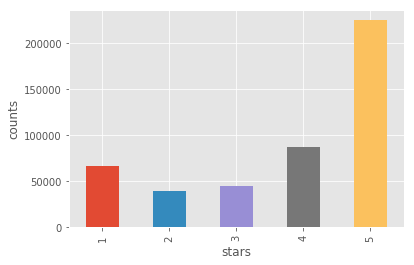

In [11]:
p=df_recommend['stars'].value_counts().sort_index().plot(kind='bar')
p.set(xlabel="stars", ylabel="counts")
plt.rcParams.update({'font.size': 10})

In [9]:
user_reviews = df_recommend.groupby('user_id').business_id.nunique()

In [10]:
user_reviews.head(3)

user_id
---94vtJ_5o_nikEs6hUjg    1
---PLwSf5gKdIoVnyRHgBA    1
--0LlX_UcypHnxW-4BUAdA    1
Name: business_id, dtype: int64

In [11]:
user_reviews.describe()
# suggest user give 2.6 review on average, user can give at most 335 reviews

count    180906.000000
mean          2.559147
std           5.208918
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         335.000000
Name: business_id, dtype: float64

In [ ]:
# find users who give the most reviews
#df['review_count'] = df.groupby(['user_id'])['business_id'].transform('count')
#df['review_count'].quantile(q=(0.25, 0.5, 0.75, 0.90))

In [ ]:
#df_top_user = df[df['review_count'] == df['review_count'].max()].copy()

In [ ]:
#df_top_user['user_id'].value_counts()

In [12]:
business_reviews = df_recommend.groupby('business_id').user_id.nunique()
business_reviews.head(3)

business_id
-01XupAWZEXbdNbxNg5mEg    29
-050d_XIor1NpCuWkbIVaQ     1
-092wE7j5HZOogMLAh40zA    23
Name: user_id, dtype: int64

In [13]:
business_reviews.describe()
# suggest each restaurant recieve 55 reviews on average

count    8476.000000
mean       54.620694
std        80.026464
min         1.000000
25%         9.000000
50%        26.000000
75%        69.000000
max      1061.000000
Name: user_id, dtype: float64

#### exlude user_id that do not give many reviews

In [14]:
# count review number for each user_id
df_copy = df.groupby(['user_id']).size().reset_index(name='counts') 

# select user_id that give more than 55 reviews, because on average a restaurant received 55 reviews
counts_condition = df_copy['counts'] >= 55

# convert pandas series into ndarray by .values, then make it as set
select_user_id = set(df_copy[counts_condition]['user_id'].values)

In [15]:
print('number of user_id been selected: ', len(select_user_id))

('number of user_id been selected: ', 294)


In [16]:
# filter user_id that has been selected 

def keep(row):
    if row['user_id'] in select_user_id:
        val = 1
    else:
        val = 0
    return val
df['keep'] = df.apply(keep,axis = 1)

In [17]:
condition = df['keep'] == 1
df_final = df[condition]

In [18]:
df_final.shape

(25062, 14)

In [19]:
df_final = df_final.reset_index()

#### create utility matrix 

In [23]:
df_utility = pd.pivot_table(data=df_final, 
                            index='user_id',
                            values='stars', 
                            columns='business_id', 
                            fill_value=0)

In [24]:
df_utility.shape

(294, 5523)

In [28]:
df_utility.head(3)

business_id,-01XupAWZEXbdNbxNg5mEg,-092wE7j5HZOogMLAh40zA,-0WegMt6Cy966qlDKhu6jA,-0aIra_B6iALlfqAriBSYA,-0tgMGl7D9B10YjSN2ujLA,-1UMR00eXtwaeh59pEiDjA,-1VaIJza42Hjev6ukacCNg,-2isRNVb6PDuBagELL5EBw,-34vSRcMz_RjN00dWIiQ3Q,-3oxnPPPU3YoxO9M1I2idg,...,ztP466jMUMtqLwwHqXbk9w,ztcdHj6EpUD7EemcntSsrg,zttn4Vekrnd5wEPxgqNvug,zuVvDYJkKAbXQTTBauAqJQ,zusXbyXnJfS1Q-pZE9elmQ,zvB0Vzhomsodw_iQ7FHY1Q,zwNLJ2VglfEvGu7DDZjJ4g,zwmps5SXn30g-f5wqg_r9A,zyPGYeXF4XKCqNN1pjFWhg,zzwicjPC9g246MK2M1ZFBA
user_id,,,,,,,,,,,,,,,,,,,,,
-0udWcFQEt2M8kM3xcIofw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-8rSnT5ztVk6vmTDkxTqsQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9S_Fh-sQebyB1yhEM5zHw,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [29]:
df_mat = df_utility.as_matrix()

In [30]:
df_mat.shape,df_utility.shape

((294, 5523), (294, 5523))

In [31]:
# Compressed Sparse Row matrix

from scipy import sparse
ratings_mat = sparse.csr_matrix(df_mat)

In [32]:
ratings_mat

<294x5523 sparse matrix of type '<type 'numpy.int64'>'
	with 25062 stored elements in Compressed Sparse Row format>

#### item-item similarity recommender

In [33]:
utility_mat = ratings_mat

In [34]:
# Item-Item Similarity Matrix

from sklearn.metrics.pairwise import cosine_similarity
item_sim_mat = cosine_similarity(utility_mat.T)

In [35]:
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)

# Neighborhoods
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

In [36]:
neighborhoods.shape

(5523, 75)

In [40]:
# random choose user_id, and make recommendation
user_id = 218

In [41]:
from time import time
n_users = utility_mat.shape[0]
n_items = utility_mat.shape[1]

start_time = time()
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
# Just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection op
    out[item_to_rate] = ratings_mat[user_id, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()


pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))

[4. 3. 0. ... 0. 5. 4.]
Execution time: 2.298868 seconds


In [42]:
# Get final recommendation
# Recommend n choices
n = 10

# get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# find items that have been rated by user
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

# exclude the items that have been rated by user
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[4272, 3017, 2378, 1091, 1717, 2788, 1484, 2613, 3296, 816]

In [43]:
business_id_lst = df_final['business_id'].unique()
business_id_dict = {k: v for v, k in enumerate(business_id_lst)}
df_final['business_id_map'] = df_final.apply(lambda x: business_id_dict[x['business_id']], axis=1)

In [44]:
business_id_map_top_n = unrated_items_by_pred_rating[:n]
rec_business_name_lst = []
for id_map in business_id_map_top_n:
    #print id_map
    rec_business_name_lst.append(df_final[df_final['business_id_map'] == id_map]['name'].unique()[0])

rec_business_name_lst

['Everything Bagels',
 'Mikado Sushi',
 "Palermo's Pizza & Wings",
 'Sushi Stop Udon & Grill',
 'Atlas Bistro',
 'Chennai Fusion Grill',
 'Los Favoritos',
 "Big Jimmy's",
 "Pacino's Italian",
 'Which Wich']

#### matrix factorization recommender
#### 1.NMF

In [46]:
from sklearn.decomposition import NMF

def fit_nmf(M,k):
    nmf = NMF(n_components=k)
    nmf.fit(M)
    W = nmf.transform(M);
    H = nmf.components_;
    err = nmf.reconstruction_err_
    return W,H,err

# decompose
W,H,err = fit_nmf(ratings_mat,169)
print(err)
print(W.shape,H.shape)

321.163026443915
((294, 169), (169, 5523))


In [47]:
# reconstruct
ratings_mat_fitted = W.dot(H)
errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

3.3525645676840417
1.0843299025964888


In [48]:
# get recommendations for the same user

user_id = 218
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[289, 3178, 5335, 2479, 4047, 1518, 4954, 2694, 5313, 10]

In [49]:
business_id_map_top_n_NVM = unrated_items_by_pred_rating[:n]
rec_business_name_lst_NVM = []
for id_map in business_id_map_top_n_NVM:
    #print id_map
    rec_business_name_lst_NVM.append(df_final[df_final['business_id_map'] == id_map]['name'].unique()[0])

rec_business_name_lst_NVM

['Kodo Sushi Sake',
 "Egg N' Joe",
 "D'lite Healthy On The Go",
 'Proof',
 'Modern Margarita',
 "Eden's Grill Inn",
 "Rita's Kitchen & R Bar",
 'Federal Pizza',
 'The Covenant',
 "Roland's Cafe Market Bar"]

In [50]:
### check errors
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()

# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]

print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
print(err_one_user)
print(abs(err_one_user).mean())

[(5, 4.829231392511372), (4, 4.237113756722353), (4, 3.945804603938651), (5, 4.828498680842989), (4, 4.136292955287677), (5, 4.731747400491311), (5, 5.000391081515752), (5, 4.9615934723387545), (3, 2.862711126726842), (4, 4.211950530293124), (4, 3.598129677802021), (5, 4.896722314382775), (5, 4.879312995472794), (4, 3.8403352622455147), (4, 3.849971930111493), (4, 3.7603247561059088), (4, 3.872323169482371), (4, 3.8296838519677796), (3, 3.0235636628962617), (4, 3.8149457446044703), (5, 4.659018553733263), (4, 4.122212529943341), (4, 3.9119401896883357), (4, 4.406322906293504), (4, 3.75900794743424), (4, 4.18066486238224), (4, 3.9632947569824317), (5, 4.833489164914977), (3, 2.756322355731598), (4, 3.936123384340995), (5, 4.8126491145411805), (5, 4.789006474124089), (5, 4.97750573213329), (4, 4.318848968207915), (5, 5.177759803048294), (4, 4.041873875706428), (4, 3.824643243024032), (5, 4.840403961852963), (5, 5.107662340915902), (5, 4.682964602841969), (4, 3.9341518800075184), (3, 2.90

#### 2. UVD/SVD

In [51]:
from sklearn.decomposition import TruncatedSVD

def fit_uvd(M,k):
    svd = TruncatedSVD(n_components=k, n_iter=7, random_state=0)
    svd.fit(M)

    V = svd.components_
    U = svd.transform(M) 

    return U,V, svd

# decompose
U,V,svd = fit_uvd(ratings_mat,169)

In [52]:
print(U.shape,V.shape)

((294, 169), (169, 5523))


In [53]:
ratings_mat_fitted = U.dot(V) 

errs = np.array((ratings_mat-ratings_mat_fitted).flatten()).squeeze()
mask = np.array((ratings_mat.todense()).flatten()).squeeze()>0

mse = np.mean(errs[mask]**2)
average_abs_err = abs(errs[mask]).mean()
print(mse)
print(average_abs_err)

1.6378557353442986
0.9073554511902541


In [54]:
# compare with another way to reconstruct matrix

ratings_mat_fitted_2 = svd.inverse_transform(svd.transform(ratings_mat))
ratings_mat_fitted = U.dot(V)
print(sum(sum(ratings_mat_fitted - ratings_mat_fitted_2)))

0.0


In [55]:
# get recommendations for one user
user_id = 218
n = 10

pred_ratings = ratings_mat_fitted[user_id,:]
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]

unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[3938, 4580, 3743, 4047, 3567, 3661, 1158, 2823, 3095, 3866]

In [56]:
business_id_map_top_n_SVD = unrated_items_by_pred_rating[:n]
rec_business_name_lst_SVD = []
for id_map in business_id_map_top_n_SVD:
    #print id_map
    rec_business_name_lst_SVD.append(df_final[df_final['business_id_map'] == id_map]['name'].unique()[0])

rec_business_name_lst_SVD

['Toyama',
 'Zinburger',
 "Joe's Midnight Run",
 'Modern Margarita',
 'The District',
 'The Chicken Scoop',
 'Spiga Cucina',
 'True Food Kitchen',
 'SOL Mexican Cocina',
 'OBON Sushi Bar Ramen']

In [57]:
### check errors
ratings_true = ratings_mat[user_id, items_rated_by_this_user].todense()

# prediction
ratings_pred = pred_ratings[items_rated_by_this_user]
print(list(zip(np.array(ratings_true).squeeze(),ratings_pred)))
err_one_user = ratings_true-ratings_pred
print(err_one_user)
print(abs(err_one_user).mean())

[(5, 3.0143755252601245), (4, 2.4302226038302965), (4, 3.5853683409819013), (5, 3.1091199967569625), (4, 4.019024770254777), (5, 3.391989581671839), (5, 3.9695143579686105), (5, 4.01951026681468), (3, 1.8320628557327128), (4, 2.619892327046581), (4, 2.2421162525325333), (5, 4.096158013671195), (5, 4.047366601551783), (4, 2.564410426715767), (4, 2.39728594475517), (4, 3.521424465177923), (4, 2.4450803821008997), (4, 2.7512634104571965), (3, 1.8190079014670693), (4, 2.2089339932561467), (5, 3.865566873207877), (4, 2.7153538884491604), (4, 2.513039473008522), (4, 3.9714061624558483), (4, 2.282652211208538), (4, 3.1835730320430287), (4, 3.388968359714871), (5, 3.3597922859460256), (3, 1.7540424603920208), (4, 3.791385285134458), (5, 3.03754718793955), (5, 3.2786827611755593), (5, 4.0953510729736005), (4, 3.214410429665929), (5, 3.7593091488468158), (4, 2.9356166859856163), (4, 2.8456108290866915), (5, 2.97873851510169), (5, 4.589539774891927), (5, 3.3907080974913923), (4, 2.833562000902472